<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/model%20layers%20pop/200%20instance_2000%20pair_%208%20outer%20shift_Threshold%20verification%20with%20Middle_TP-FN_TN-FP_FAR-FFR-EER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
* verification with middle of data --- test threshold

subject number = 109 >> 90 train subject  + 19 new subject 
channel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]

model3 -  1 layer pop

'''


'\ncounter true and false verification\n\nsubject number = 109 >> 90 train subject  + 19 new subject \nchannel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]\n\nmodel3 -  1 layer pop\n\n'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install mne

     |████████████████████████████████| 6.4MB 2.8MB/s 


In [0]:
'''
Rivision:
980806:
  First version.
  
  

'''

'\nRivision:\n980806:\n  First version.\n  \n  \n\n'

In [0]:
# Parameters:

EpochNum=60
subject_numberT=109
RemoveBaseLine=0
Orthogonal=1
task_index = [1] # task: REO
list_channel=[21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
TryStr='Try1'
seed = 14

task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
#sample_shift = 4 #step len
inner_sample_shift = 4 # inner step len
outer_sample_shift =8  # outer step len
#sample_per_window = 160
window_len= 20
batch_size=64




In [40]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import itertools
from itertools import combinations 
import statistics
import csv
import os.path
from scipy.spatial import distance
import numpy as np
import math
import random
import datetime
import time
import pytz
from time import gmtime, strftime

# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend
from keras.models import load_model



# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Automatically created module for IPython interactive environment


In [41]:
# load dataset in array
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_numberT
for x in range(subject_numberT):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database')

list_rawdata = np.zeros((subject_numberT,task_number), dtype='object')

for i in range(subject_numberT):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S004/S004R01.edf...
EDF file detected


In [42]:
subject_number = 90
# new subject
new_subject =np.arange(subject_number, subject_numberT)

# img for each subject
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1
np.random.seed(seed)  

subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

subject_img_number_array_shuffled=np.arange(subject_img_number)
np.random.shuffle(subject_img_number_array_shuffled)

train_index = len(subject_img_number_array_shuffled)//2
val_index = train_index + len(subject_img_number_array_shuffled)//4

train_shuff = subject_img_number_array_shuffled[:train_index]
val_shuff = subject_img_number_array_shuffled[train_index:val_index]
test_shuff = subject_img_number_array_shuffled[val_index:]


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)
print(train_number , val_number, test_number)
subject_img_number


585 292 294


1171

In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(BatchSize,ListRawDataMain,SubjectArrayShuffled,ListChannel,RemoveBaseLineFlag,OrthogonalFlag,ImageArrayShuffled,WindowLen,OuterSampleShift,InnerSampleShift,SampelNumberPerSec):
    
    Iter=0
    #ch_number=len(ListChannel)
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][0][:64,:9600])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    e= 0    
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][0][:64,:9600])
        
        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        
        for i in range(len(ListChannel)):
            DataChannelsRaw[e][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() -DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[e][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[e][i])) # min for each cannel

            DataChannelsNormal[e][i]=normalize_channel_data(DataChannelsRaw[e][i].copy(), i, ch_min, ch_max)
        e = e+1

        # Orthogonal Channel
        #DataChannelsOrt[e][0]=DataChannelsNormal[e][0]
        #DataChannelsOrt[e][1]=DataChannelsNormal[e][1]-ProjectionVector(DataChannelsNormal[e][0].copy(),DataChannelsNormal[e][1].copy())*OrthogonalFlag
        
        
        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          r = 0
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  TrainImage=np.zeros((BatchSize, ch_number, WindowLen, SampelNumberPerSec), dtype = float)
                  TrainLabel=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsNormal[r][i][0+j*OuterSampleShift + z*InnerSampleShift:SampelNumberPerSec+ j*OuterSampleShift + z*InnerSampleShift]
                      TrainImage[Iter][i][z] = ExtractedData.copy()# Data
              r=r+1

              TrainLabel[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                TrainLabelClass=to_categorical(TrainLabel,subject_numberT)
                TI = np.moveaxis(TrainImage, 1, -1)
                yield TI, TrainLabelClass 

                

In [0]:
ch_number=len(list_channel)
list_rawdataTemp=list_rawdata.copy()


In [0]:
#model.save('/content/drive/My Drive/mymodels/model1.h5')

In [11]:
model = load_model('/content/drive/My Drive/mymodels/model2_2.h5')
model.summary()
model.pop()
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 20, 160, 64)       11584     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 80, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 78, 128)        73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 39, 128)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 37, 256)        295168    
____________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
def subject_Predict_generator(batch_size, mymodel, subject_arr, img_arr ):
  sn = len(subject_arr)
  imgn = len(img_arr)
  pre_GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled= subject_arr,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled= img_arr)

  pre_Subject = mymodel.predict_generator(pre_GenTestData,steps=np.ceil(imgn*sn/batch_size))
  return pre_Subject


In [0]:
total_vector=[]
subject_img_idx_array = np.arange(subject_img_number)

for i in range(108):
  Si_vectors = subject_Predict_generator(len(subject_img_idx_array), model, [i], subject_img_idx_array)
  total_vector.append(Si_vectors)



In [0]:
import h5py

In [0]:
hf = h5py.File('/content/drive/My Drive/Deep Results/total_vectors.h5', 'w')


In [60]:
hf.create_dataset('/content/drive/My Drive/Deep Results/dataset_total_vectors', data=total_vector)

<HDF5 dataset "dataset_total_vectors": shape (108, 1171, 64), type "<f4">

In [0]:
hf.close()


In [0]:
hf = h5py.File('/content/drive/My Drive/Deep Results/total_vectors.h5', 'r')

In [63]:
n1 = hf.get('/content/drive/My Drive/Deep Results/dataset_total_vectors')
n1

<HDF5 dataset "dataset_total_vectors": shape (108, 1171, 64), type "<f4">

In [64]:
n1 = np.array(n1)
n1.shape

(108, 1171, 64)

In [0]:
### verification with middle of samples

def VerifySubject(threshold, s1, smp1, s2, smp2):
  list_d =[]

  for i in range(len(smp1)):
    #print(s1 ,vec1[i] )
    d= distance.euclidean(n1[s1][smp1[i]], n1[s2][smp2[i]])
    list_d.append(d)
    midd = statistics.median_low(list_d)

  if (midd) <threshold :
    return 0 # same
  else:
    return 1 # different


In [0]:


### generate data for verification
def counter_true_false_result(start_index_s1, end_index_s1 ,start_index_s2, end_index_s2 ):
  
  threshold = 0
  pair_number = 2
  sample_img_num = 200
  Batch_size = 55
  ITER = pair_number //2


  path = "/content/drive/My Drive/z_Middle Verification Threshold_EER/" +str(sample_img_num)+"sample num_"+str(pair_number)+"pair_"+ "ouer shift" + str(outer_sample_shift)

  try:
      os.mkdir(path)
  except OSError:
      print ("Creation of the directory %s failed" % path)
  else:
      print ("Successfully created the directory %s " % path)



  
  ## CSV file name 
  csvFileName =str(sample_img_num)+"sample num_"+str(pair_number)+"pair"+ "_MIDDLE threshold_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")" +".csv"
  completeName = os.path.join(path, csvFileName )

  png_FileName =str(sample_img_num)+"sample num_"+str(pair_number)+"pair"+ "_MIDDLE threshold_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")" +".png"
  png_completeName = os.path.join(path, png_FileName )

  list_threshold = []
  list_TP = []
  list_TN = []
  list_FP = []
  list_FN = []
  list_FRR = []
  list_FAR = []
  list_EER = []
  list_Correct_Verifi_Percentage = []
  list_threshold_result =[]


  for j in range(60,80):

      #threshold = j*2
      threshold = j
      TP =0
      TN =0
      FP =0
      FN =0
      FAR =0
      FRR =0
      EER =0
      true_result= 0
      false_result = 0
      Correct_Verifi_Percentage = 0

      for i in range(ITER):
        
          # subject 1 Genuine
          S1_rand = random.randint(start_index_s1, end_index_s1)
          # shuffled img indx array
          pre_S1_img_shuffled = np.arange(subject_img_number)
          np.random.shuffle(pre_S1_img_shuffled)

          # group sample 1
          S1_Sample_rand1 = pre_S1_img_shuffled[:sample_img_num]
          # group sample 2
          S1_Sample_rand2 = pre_S1_img_shuffled[sample_img_num : sample_img_num *2]

          # Genuine verify
          result1 = VerifySubject( threshold, S1_rand, S1_Sample_rand1, S1_rand, S1_Sample_rand2)
          
          if result1 == 0:
            true_result = true_result+1
            TP = TP +1 #TP
          else:
            false_result = false_result+1
            FN = FN +1

          # subject 2
          S2_rand = random.randint(start_index_s2, end_index_s2)
          while S2_rand == S1_rand:
            S2_rand = random.randint(start_index_s2, end_index_s2)

          # shuffled img indx array
          pre_S2_img_shuffled=np.arange(subject_img_number)
          np.random.shuffle(pre_S2_img_shuffled)
          # group sample
          S2_Sample_rand = pre_S2_img_shuffled[:sample_img_num]

          # Impostor vrify
          result2 = VerifySubject( threshold, S1_rand, S1_Sample_rand1, S2_rand, S2_Sample_rand)

          if result2 == 1:
            true_result = true_result+1
            TN = TN +1
          else: 
            false_result = false_result+1
            FP = FP +1
        
      #print(result1 , result2)
      Correct_Verifi_Percentage = (true_result *100) / (true_result + false_result)
      FAR = FP / (FP+TN)
      FRR = FN / (FN+TP)
      EER = (FAR+FRR) / 2

      list_threshold.append(threshold)
      list_TP.append(TP)
      list_TN.append(TN)
      list_FP.append(FP)
      list_FN.append(FN)
      list_FAR.append(FAR)
      list_FRR.append(FRR)
      list_EER.append(EER)
      list_Correct_Verifi_Percentage.append(Correct_Verifi_Percentage)
      ## print result
      print(threshold,'.', '\n', Correct_Verifi_Percentage,'%','\n',"true_result:",true_result,"false_result:",false_result,'\n',"TP:",TP,"FN:",FN,"FRR:",FRR ,'\n',"TN:",TN,"FP:",FP,"FAR:", FAR,'\n',"EER:",EER,'\n' )

  ##plot
  plt.plot(list_FRR, list_FAR  ) 
  plt.xlabel('FRR') 
  plt.ylabel('FAR') 
  plt.legend()
  plt.savefig(png_completeName) 


  list_threshold_result.append([(list_threshold[j], list_Correct_Verifi_Percentage[j], list_TP[j], list_FN[j], list_TN[j], list_FP[j], list_FAR[j], list_FRR[j] , list_EER[j] ) for j in range(len(list_Correct_Verifi_Percentage)) ])

  with open(completeName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                          quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(list_threshold_result[0])


60 . 
 91.5 % 
 true_result: 1830 false_result: 170 
 TP: 835 FN: 165 FRR: 0.165 
 TN: 995 FP: 5 FAR: 0.005 
 EER: 0.085 

61 . 
 92.6 % 
 true_result: 1852 false_result: 148 
 TP: 858 FN: 142 FRR: 0.142 
 TN: 994 FP: 6 FAR: 0.006 
 EER: 0.074 

62 . 
 92.55 % 
 true_result: 1851 false_result: 149 
 TP: 862 FN: 138 FRR: 0.138 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.07450000000000001 

63 . 
 93.4 % 
 true_result: 1868 false_result: 132 
 TP: 878 FN: 122 FRR: 0.122 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.066 

64 . 
 94.05 % 
 true_result: 1881 false_result: 119 
 TP: 894 FN: 106 FRR: 0.106 
 TN: 987 FP: 13 FAR: 0.013 
 EER: 0.0595 

65 . 
 95.1 % 
 true_result: 1902 false_result: 98 
 TP: 918 FN: 82 FRR: 0.082 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.049 

66 . 
 96.0 % 
 true_result: 1920 false_result: 80 
 TP: 937 FN: 63 FRR: 0.063 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.04 

67 . 
 95.65 % 
 true_result: 1913 false_result: 87 
 TP: 942 FN: 58 FRR: 0.058 
 TN: 971 FP: 29 FAR: 0.029 
 EER: 0.043500

No handles with labels found to put in legend.


79 . 
 91.95 % 
 true_result: 1839 false_result: 161 
 TP: 968 FN: 32 FRR: 0.032 
 TN: 871 FP: 129 FAR: 0.129 
 EER: 0.0805 



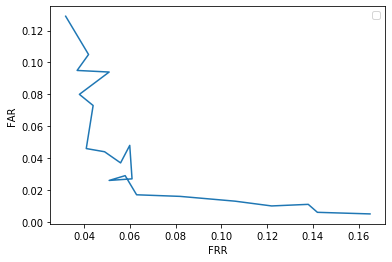

In [84]:
#1. train subject , train subject

counter_true_false_result(0,89, 0,89) 


60 . 
 90.6 % 
 true_result: 1812 false_result: 188 
 TP: 834 FN: 166 FRR: 0.166 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.094 

61 . 
 90.55 % 
 true_result: 1811 false_result: 189 
 TP: 833 FN: 167 FRR: 0.167 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.0945 

62 . 
 91.95 % 
 true_result: 1839 false_result: 161 
 TP: 872 FN: 128 FRR: 0.128 
 TN: 967 FP: 33 FAR: 0.033 
 EER: 0.0805 

63 . 
 91.95 % 
 true_result: 1839 false_result: 161 
 TP: 870 FN: 130 FRR: 0.13 
 TN: 969 FP: 31 FAR: 0.031 
 EER: 0.0805 

64 . 
 92.1 % 
 true_result: 1842 false_result: 158 
 TP: 890 FN: 110 FRR: 0.11 
 TN: 952 FP: 48 FAR: 0.048 
 EER: 0.079 

65 . 
 94.15 % 
 true_result: 1883 false_result: 117 
 TP: 915 FN: 85 FRR: 0.085 
 TN: 968 FP: 32 FAR: 0.032 
 EER: 0.0585 

66 . 
 93.45 % 
 true_result: 1869 false_result: 131 
 TP: 921 FN: 79 FRR: 0.079 
 TN: 948 FP: 52 FAR: 0.052 
 EER: 0.0655 

67 . 
 93.85 % 
 true_result: 1877 false_result: 123 
 TP: 936 FN: 64 FRR: 0.064 
 TN: 941 FP: 59 FAR: 0.059 
 EER: 0.0615 

6

No handles with labels found to put in legend.


79 . 
 86.1 % 
 true_result: 1722 false_result: 278 
 TP: 955 FN: 45 FRR: 0.045 
 TN: 767 FP: 233 FAR: 0.233 
 EER: 0.139 



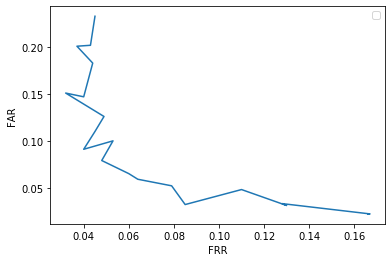

In [88]:
#2. train subject , new subject

counter_true_false_result(0,89, 90,107)


60 . 
 81.55 % 
 true_result: 1631 false_result: 369 
 TP: 656 FN: 344 FRR: 0.344 
 TN: 975 FP: 25 FAR: 0.025 
 EER: 0.1845 

61 . 
 82.6 % 
 true_result: 1652 false_result: 348 
 TP: 675 FN: 325 FRR: 0.325 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.17400000000000002 

62 . 
 82.8 % 
 true_result: 1656 false_result: 344 
 TP: 692 FN: 308 FRR: 0.308 
 TN: 964 FP: 36 FAR: 0.036 
 EER: 0.172 

63 . 
 84.8 % 
 true_result: 1696 false_result: 304 
 TP: 730 FN: 270 FRR: 0.27 
 TN: 966 FP: 34 FAR: 0.034 
 EER: 0.15200000000000002 

64 . 
 86.75 % 
 true_result: 1735 false_result: 265 
 TP: 777 FN: 223 FRR: 0.223 
 TN: 958 FP: 42 FAR: 0.042 
 EER: 0.1325 

65 . 
 86.6 % 
 true_result: 1732 false_result: 268 
 TP: 775 FN: 225 FRR: 0.225 
 TN: 957 FP: 43 FAR: 0.043 
 EER: 0.134 

66 . 
 87.0 % 
 true_result: 1740 false_result: 260 
 TP: 800 FN: 200 FRR: 0.2 
 TN: 940 FP: 60 FAR: 0.06 
 EER: 0.13 

67 . 
 87.85 % 
 true_result: 1757 false_result: 243 
 TP: 809 FN: 191 FRR: 0.191 
 TN: 948 FP: 52 FAR: 0

No handles with labels found to put in legend.


79 . 
 84.5 % 
 true_result: 1690 false_result: 310 
 TP: 940 FN: 60 FRR: 0.06 
 TN: 750 FP: 250 FAR: 0.25 
 EER: 0.155 



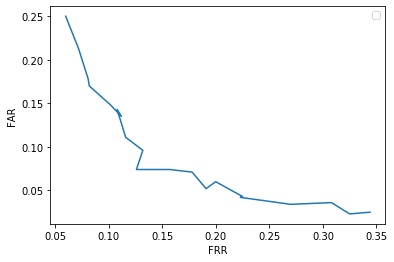

In [89]:
#3. new subject , new subject

counter_true_false_result(90,107, 0,89)

60 . 
 80.5 % 
 true_result: 1610 false_result: 390 
 TP: 664 FN: 336 FRR: 0.336 
 TN: 946 FP: 54 FAR: 0.054 
 EER: 0.195 

61 . 
 80.7 % 
 true_result: 1614 false_result: 386 
 TP: 668 FN: 332 FRR: 0.332 
 TN: 946 FP: 54 FAR: 0.054 
 EER: 0.193 

62 . 
 83.0 % 
 true_result: 1660 false_result: 340 
 TP: 708 FN: 292 FRR: 0.292 
 TN: 952 FP: 48 FAR: 0.048 
 EER: 0.16999999999999998 

63 . 
 84.05 % 
 true_result: 1681 false_result: 319 
 TP: 742 FN: 258 FRR: 0.258 
 TN: 939 FP: 61 FAR: 0.061 
 EER: 0.1595 

64 . 
 83.4 % 
 true_result: 1668 false_result: 332 
 TP: 745 FN: 255 FRR: 0.255 
 TN: 923 FP: 77 FAR: 0.077 
 EER: 0.166 

65 . 
 83.6 % 
 true_result: 1672 false_result: 328 
 TP: 772 FN: 228 FRR: 0.228 
 TN: 900 FP: 100 FAR: 0.1 
 EER: 0.164 

66 . 
 85.65 % 
 true_result: 1713 false_result: 287 
 TP: 813 FN: 187 FRR: 0.187 
 TN: 900 FP: 100 FAR: 0.1 
 EER: 0.14350000000000002 

67 . 
 84.8 % 
 true_result: 1696 false_result: 304 
 TP: 813 FN: 187 FRR: 0.187 
 TN: 883 FP: 117 FAR:

No handles with labels found to put in legend.


79 . 
 74.1 % 
 true_result: 1482 false_result: 518 
 TP: 929 FN: 71 FRR: 0.071 
 TN: 553 FP: 447 FAR: 0.447 
 EER: 0.259 



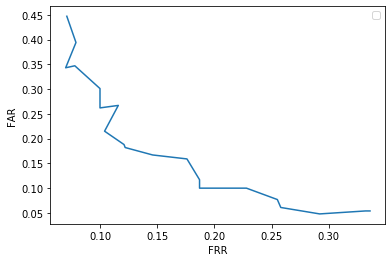

In [90]:
#4. new subject , new subject

counter_true_false_result(90,107, 90,107)


60 . 
 90.25 % 
 true_result: 1805 false_result: 195 
 TP: 816 FN: 184 FRR: 0.184 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.0975 

61 . 
 90.75 % 
 true_result: 1815 false_result: 185 
 TP: 831 FN: 169 FRR: 0.169 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.0925 

62 . 
 90.3 % 
 true_result: 1806 false_result: 194 
 TP: 827 FN: 173 FRR: 0.173 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.09699999999999999 

63 . 
 92.1 % 
 true_result: 1842 false_result: 158 
 TP: 861 FN: 139 FRR: 0.139 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.079 

64 . 
 92.6 % 
 true_result: 1852 false_result: 148 
 TP: 882 FN: 118 FRR: 0.118 
 TN: 970 FP: 30 FAR: 0.03 
 EER: 0.074 

65 . 
 93.3 % 
 true_result: 1866 false_result: 134 
 TP: 896 FN: 104 FRR: 0.104 
 TN: 970 FP: 30 FAR: 0.03 
 EER: 0.067 

66 . 
 94.25 % 
 true_result: 1885 false_result: 115 
 TP: 913 FN: 87 FRR: 0.087 
 TN: 972 FP: 28 FAR: 0.028 
 EER: 0.057499999999999996 

67 . 
 93.6 % 
 true_result: 1872 false_result: 128 
 TP: 907 FN: 93 FRR: 0.093 
 TN: 965 FP: 35 FAR:

No handles with labels found to put in legend.


79 . 
 89.35 % 
 true_result: 1787 false_result: 213 
 TP: 959 FN: 41 FRR: 0.041 
 TN: 828 FP: 172 FAR: 0.172 
 EER: 0.1065 



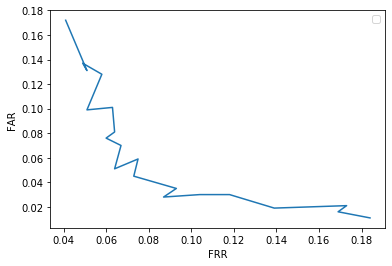

In [91]:
#5. all subject , all subject

counter_true_false_result(0,107, 0,107)
